In [1]:
%load_ext autoreload
%autoreload 2
%set_env PYTHONBREAKPOINT=IPython.core.debugger.set_trace

env: PYTHONBREAKPOINT=IPython.core.debugger.set_trace


In [16]:
# IMPORTS #
%matplotlib notebook
from utils import *
from word2vec_example import *
from embed_documents import *
from plot import *
import numpy as np

# In this notebook I will explore word embeddings and how we can leverage them for working with documents.
### In our case these are Wikipedia article summaries. 
The full code for this notebook can be found at #TODO#.

# A brief primer on word embeddings

Word embeddings, and particularly [word2vec](https://arxiv.org/pdf/1301.3781.pdf), was one of the most impactful applications of deep learning to NLP. The concept behind word embeddings is to learn vector representation of words such that words that are similar, semantically and/or syntactically, are close together in this vector space. Word2Vec provided a way to efficiently learn word embeddings that encode semantics, syntax, and relationships between words. To learn more about word2vecs's implementation I recommend [McCormick ML's tutorial](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/). The main takeaway about word embeddings is however that we can learn these embeddings without any supervised labels (this is a form of semi-supervised learning). We can thus learn embeddings using a very large corpus of text and then leverage the resulting vectors as features for downstream prediction tasks in models like neural networks.

I use [spaCy's](https://spacy.io/usage/spacy-101) tokenizer for processing text. We also load their en_core_web_md model with comes built in with word2vec embeddings for English text. 

In [3]:
nlp = load_nlp()

#### Let's see an example of word embeddings in action.

In [4]:
example_words = ['king', 'queen', 'man', 'woman']
embedding_dict = get_example_embedding_dict(example_words, nlp)

Our word embeddings are of size 300 and normalized to unit norm.
Here's an example of the first 5 entries of the word embedding for 'king':
[ 0.04416567 -0.04910284  0.06010155 -0.07536674 -0.02587603]


#### Similarities
To compare two word embeddings, $v, u \in \mathbb{R}^{300}$ we use the dot product. That is: 
$$sim(u, v) = u \cdot v$$
This is equivalent to cosine similarity for normalized vectors. When computing similarities we get a number $s \in [-1, 1]$ where the sign of $s$ represents if the two vectors face the same direction or not, and the magnitude $|s|$ represents closeness, if the two vectors faced the same direction.

In [5]:
get_example_similarities(embedding_dict)

Calculating Similarities...
Between 'king' and 'king' = 1.00
Between 'queen' and 'king' = 0.73
Between 'man' and 'king' = 0.41
Between 'woman' and 'king' = 0.27

Calculating Euclidean distances...
Between 'king' and ('king' - 'man') = 0.59
Between 'queen' and ('king' - 'man') = 0.45
Between 'man' and ('king' - 'man') = -0.59
Between 'woman' and ('king' - 'man') = -0.47


From above first we can see that the word embeddings are able to represent things like that *queen* is similar to *king*, and *man* is more similar to *king* than *woman* is. 

Next we see that word embeddings are able to encode relationships between words. For example, we see that the embedding for (*king* - *man*), created by subtracting the corresponding embeddings, becomes more similar to the embedding for *queen*! Now we will move on to apply word embeddings in some interesting ways on Wikipedia articles.

# Get data

I use wrapper classes around [wikipediaapi](https://github.com/martin-majlis/Wikipedia-API) and [textacy's corpus class](https://chartbeat-labs.github.io/textacy/_modules/textacy/corpus.html#Corpus). This will make it easy for us to pull the wikipedia article summaries and then process them for future use. The wikipedia categories I will use are below. For each of these categories I pull the articles under these categories, and then extract and processs their summaries

To preprocess our text I normalize white space and filter out punctuation for consistency in tokenization. I also filter out stop words, as their embeddings don't add much information for the document embeddings that we will create.



I chose [Machine learning](https://en.wikipedia.org/wiki/Category:Machine_learning) and [Physical quantities](https://en.wikipedia.org/wiki/Category:Physical_quantities) as our categories because there are a lot of connections between the two fields (*physical quantites* refers to physical quantities as a subcategory under *physics*). There is overlap in the language and words used amongst articles in these categories, as well as general overlap due the mathematical foundations of both areas. Thus, if we are able to create document embeddings that seperate these classes we can be more confident that this is due to capturing of meaning. Also, we will later use embeddings to try to find related articles in these categories!

In [6]:
SELECTED_CATEGORIES = [
    "Category:Machine learning",
    "Category:Physical quantities",
]
corpus = CorpusWrapper(nlp)
corpus.load_records(SELECTED_CATEGORIES, WikiApiWrapper())
display_record_info(SELECTED_CATEGORIES, corpus)

Loading articles under Category:Machine learning
Loading articles under Category:Physical quantities

CATEGORY:MACHINE LEARNING
Num docs = 126, Avg words per doc = 70.76984126984127

CATEGORY:PHYSICAL QUANTITIES
Num docs = 120, Avg words per doc = 73.58333333333333

Total Docs = 246, Avg words per doc = 72.14227642276423


# Creating document embeddings

Now we will use word embeddings to generate embeddings for a document! A simple, but surprisingly effective method is to simply represent a document as the average of its word vectors. It would be hard to expect this method to work well for longer documents, as we are compressing a document with some $n$ words, each represented with a vector of length $300$, into a single vector of the same length. However, by using Wikipedia article summaries we hope we can represent the whole article by using just the words found in its summary. After our processing each article contains about 60 words each. 

The ```embed_doc``` function below simply takes the sequence of words that we have stored for a particular article summary, $$d = (w_1, w_2, ..., w_n)$$ and averages them as 
$$
\text{embed_doc}(d) = \frac{1}{n} \sum_{i=1}^n e(w_i)
$$
where $e(w) =$ word embedding for a word $w$. This is a simple average pooling of word vectors.
Implicitly we weight words by their frequency because we do not filter out repeated occurences of a given word.

In [7]:
def embed_doc(doc):
    return np.mean([token.vector for token in doc], axis=0)

Now that we have vector representations for all our documents, we can use the cosine distance to get a distance between documents
$$
\text{dist}(d_1, d_2) = 1 - 
\frac{
d_1 \cdot d_2
}
{
\Vert d_1\Vert\Vert d_2\Vert
} \in [0, 1]
$$
where 
$$
d_i = \text{embed_doc(document $i$)}
$$

Now we can load our document embeddings into a matrix $X \in \mathbb{R}^{N\ \times\ 300}$, where $N =$ number of total documents. Because we have a distance function, we can perform nearest neighbors queries on documents. 

#### Load document embeddings and nearest neighbors class

In [8]:
X = load_X(corpus)
knn = build_knn(X) 

Here we can see a sample of 5 of our documents and their three nearest neighbors. We can see that the embeddings are able to relate the documents to other similar documents of the same category.

In [9]:
show_five(corpus, X, knn)

Showing some documents and their neighbors...

Title: Stochastic block model, 
Category: Category:Machine learning
NEAREST NEIGHBORS
Curse of dimensionality (distance = 0.07307785749435425) 
 Category:Machine learning
Conditional random field (distance = 0.07576769590377808) 
 Category:Machine learning
Word2vec (distance = 0.07914900779724121) 
 Category:Machine learning

Title: Acoustic impedance, 
Category: Category:Physical quantities
NEAREST NEIGHBORS
Immittance (distance = 0.09173184633255005) 
 Category:Physical quantities
Electrical reactance (distance = 0.11467409133911133) 
 Category:Physical quantities
Sound power (distance = 0.11568820476531982) 
 Category:Physical quantities

Title: Developmental robotics, 
Category: Category:Machine learning
NEAREST NEIGHBORS
Robot learning (distance = 0.05168884992599487) 
 Category:Machine learning
Center for Biological and Computational Learning (distance = 0.05551940202713013) 
 Category:Machine learning
Machine learning in bioinformat

# Visualize embeddings and reduce dimensionality with t-SNE

To visualize our $300$ dimensional document embeddings, we can use [t-Distributed Stochastic Neighbor Embedding](https://mlexplained.com/2018/09/14/paper-dissected-visualizing-data-using-t-sne-explained/) (t-SNE). t-SNE is a popular method for reducing dimnensionality and particularly visualizing high dimensional data in 2 or 3 dimensions. Essentially, t-SNE reduces the dimensionality of data in a way that tries to preserve local distances as well as taking into account global structure. The code below allows us to plot our data under a t-SNE transformation, in both 2 and 3 dimensions.

#### Visualize embeddings
If you click on points on the plots you can see the articles which they correspond to.

<IPython.core.display.Javascript object>


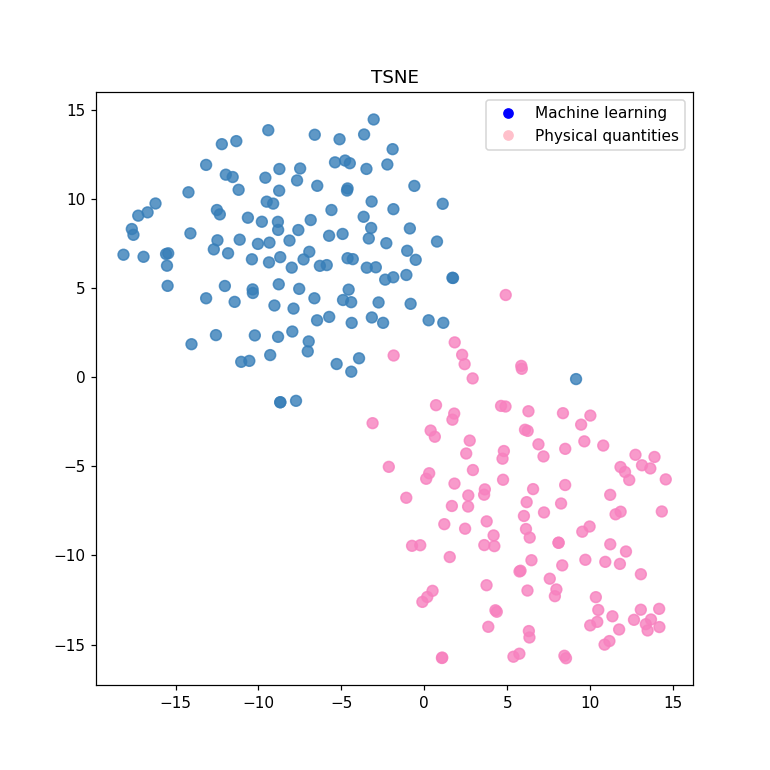

In [10]:
Xt = plot_tsne(X, 2, corpus)

<IPython.core.display.Javascript object>


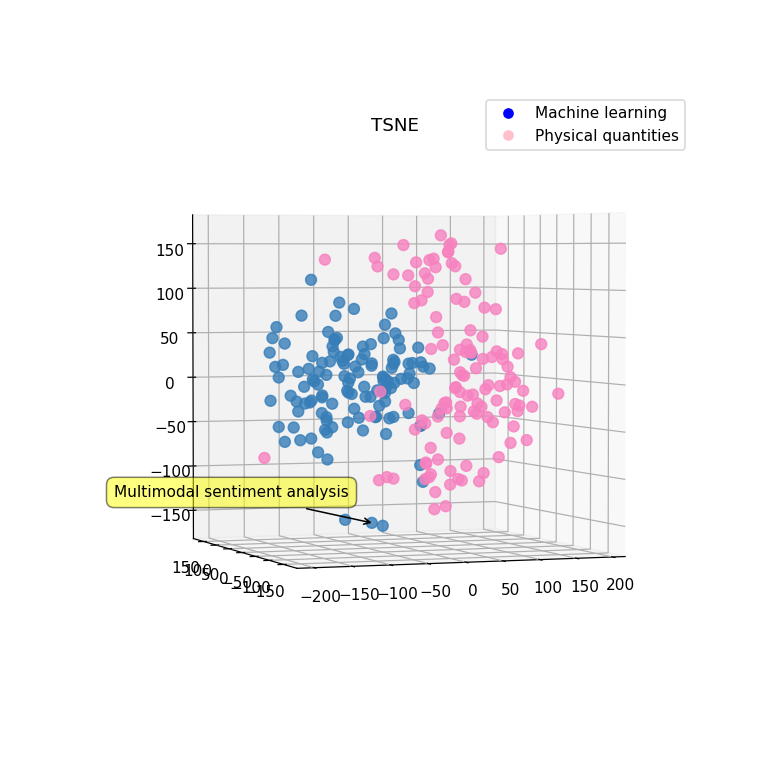

In [14]:
_ = plot_tsne(X, 3, corpus, perplexity=5, init='pca', n_iter=2000, metric='cosine')

#### Classify in t-SNE space
I noted that in the t-SNE space for the two dimensional plot, that our two categories look almost linearly seperable. Thus, below I fit a logistic regression classifier to the two dimensional t-SNE data, where the classification task is to map the low dimensional document embeddings to their original category.

In [12]:
import warnings
warnings.filterwarnings('ignore')

Xt = preprocessing.scale(Xt)
lr = LogisticRegressionCV()
Y, le = load_Y(corpus)
lr.fit(Xt, Y)
print("Accuracy = {}".format(lr.score(Xt, Y)))

Accuracy = 0.991869918699187


We see that the logistic regression classifier gets near perfect accuracy. What's nice about working with this two dimensional data is that we can now easily visualize our points in this space, as well as the logistic regression classifier boundary.

Below I plot the decision boundary of our logistic regressor as well as the probabilities that the classifer would predict over the whole grid. We can now also associate probability values with our points, on which class they belong to. Points closer to the decision boundary are the points that the classifier is least sure about. Again, the plot is interactive! By clicking on the points we can explore which articles lie where.

<IPython.core.display.Javascript object>


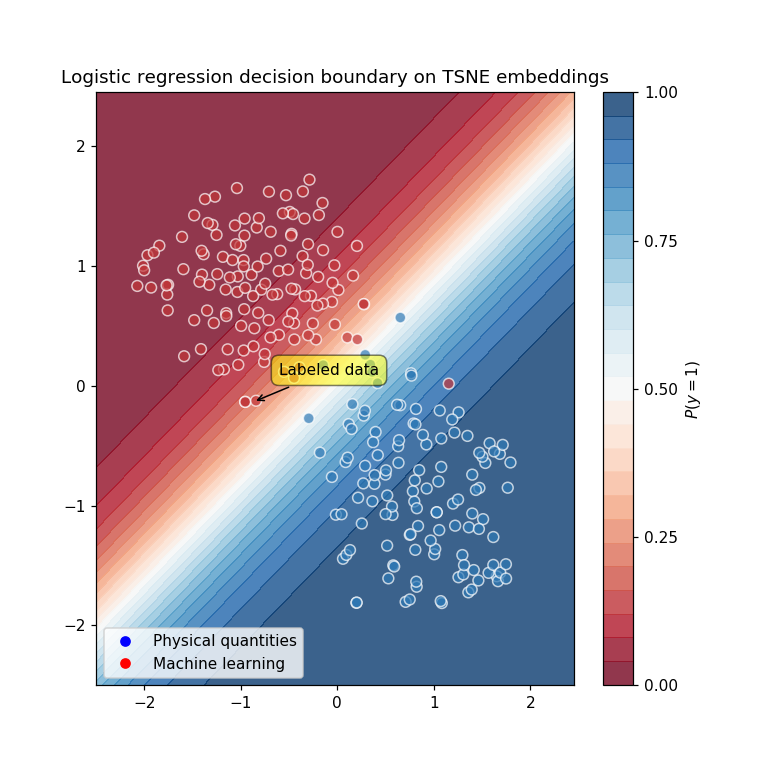

In [13]:
plot_linear_regression(lr, Xt, corpus)

The logistic regression model misclassified two documents. Let's take a look at the mistakes that our model made. 

The first error was for the article titled [Mountain car problem](https://en.wikipedia.org/wiki/Mountain_car_problem). Reading the summary for this article we can see why! It describes a physical problem setup that is used as a testbed in reinforcement learning.  It contains many physics related words such as gravity and potential energy. 

The logistic regression model assigned a probability of **0.9** of this document being of the *Physical Quantities* class. We can also see the nearest neighbors to this document in our original document embedding space. It's not surprising to see that these are all physics concepts.

In [37]:
eidxs = errors(lr.predict(Xt), Y)
print(print_neighbors(eidxs[0], corpus, X, knn))
print(lr.predict_proba(Xt[eidxs]))

Title: Mountain car problem, 
Category: Category:Machine learning
NEAREST NEIGHBORS
Speed (distance = 0.16922807693481445) 
 Category:Physical quantities
Ground pressure (distance = 0.17598378658294678) 
 Category:Physical quantities
Couple (mechanics) (distance = 0.17607080936431885) 
 Category:Physical quantities

None
[[0.09533422 0.90466578]
 [0.64996691 0.35003309]]


The second mistake was for the article titled [Quality (physics)](https://en.wikipedia.org/wiki/Quality_(physics)). Looking at this article's summary, it seems like the model made a real mistake, not due to ambiguity, as there are no machine learning related concepts. 

The model was also less sure of its prediction, assiging a probability of **0.65** of this document being in the *Machine Learning* class (and thus a **0.35** probability of being in the true class of *Physical Quantities*). We again visualize the nearest neighbors to this document in the original embedding space. We see that the two closest neighbors belong to the *Machine Learning* class. Thus we can be fairly certain that the error was due to our embeddings for this document not being a great representation. This if further supported by the fact that these two articles seem to not be related to the *Quality* article, when we look at their summaries.

In [38]:
print(print_neighbors(eidxs[1], corpus, X, knn))

Title: Quality (physics), 
Category: Category:Physical quantities
NEAREST NEIGHBORS
Curse of dimensionality (distance = 0.10454213619232178) 
 Category:Machine learning
Novelty detection (distance = 0.1074134111404419) 
 Category:Machine learning
Sound intensity (distance = 0.108040452003479) 
 Category:Physical quantities

None
